In [245]:
import sys
sys.path.append('../')
from models.preact_resnet import PreActResNet18
import torchvision
from torchvision.transforms.transforms import ToTensor, Resize, Compose
import torch
from torch.utils.data.dataloader import DataLoader
import random
from tools.img import tensor2ndarray, ndarray2tensor
from tools.img import yuv2rgb, rgb2yuv
from tools.img import fft_2d_3c, ifft_2d_3c
import pytorch_lightning as L
from tools.dataset import List2Dataset
import numpy as np
from tools.dataset import get_dataset_normalization
from tools.inject_backdoor import patch_trigger
from tools.dataset import get_dataloader
import torch.nn.functional as F
import cv2
from tools.img import get_heat_img

_ = torch.manual_seed(42)


prepare dataset

In [246]:
ratio = 0.1
dataset_name = 'imagenette'
attack_name = 'ftrojan'
target_label = 0
nw = 11
epoch = 3
lr = 0.01
momentum = 0.9
weight_decay = 5e-4

norm = get_dataset_normalization(dataset_name)
if dataset_name == 'imagenette':
    wind = 2
    batch = 64
    scale = 224
    num_classes = 10
    trans = Compose([ToTensor(), Resize((scale, scale)), norm])
    train_ds = torchvision.datasets.Imagenette(root='../data', split='train', transform=trans)
    test_ds = torchvision.datasets.Imagenette(root='../data', split='val', transform=trans)
elif dataset_name == 'cifar10':
    wind = 2
    num_classes = 10
    batch = 128
    scale = 32
    trans = Compose([ToTensor(), Resize((scale, scale)), norm])
    train_ds = torchvision.datasets.CIFAR10(root='../data', train=True, transform=trans)
    test_ds = torchvision.datasets.CIFAR10(root='../data', train=False, transform=trans)
elif dataset_name == 'gtsrb':  # bad performance
    wind = 2
    num_classes = 43
    batch = 128
    scale = 32
    trans = Compose([ToTensor(), Resize((scale, scale)), norm])
    train_ds = torchvision.datasets.GTSRB(root='../data', split='train', transform=trans)
    test_ds = torchvision.datasets.GTSRB(root='../data', split='test', transform=trans)
else:
    raise NotImplementedError(dataset_name)
train_dl = DataLoader(dataset=train_ds, batch_size=batch, shuffle=True)
test_dl = DataLoader(dataset=test_ds, batch_size=batch, shuffle=True)
poison_train_list = []
for x, y in iter(train_dl):
    for i in range(x.shape[0]):
        if random.random() < ratio:  # craft poison data
            x_re = patch_trigger(x[i], attack_name)
            x[i] = x_re
            y[i] = target_label
        poison_train_list.append((x[i], y[i]))

poison_test_list = []
for x, y in iter(test_dl):
    for i in range(x.shape[0]):
        if y[i] == target_label:
            continue
        x_re = patch_trigger(x[i], attack_name)
        x[i] = x_re
        y[i] = target_label
        poison_test_list.append((x[i], y[i]))
len(poison_train_list), len(poison_test_list)


(9469, 3538)

start train

In [247]:
class MyLightningModule(L.LightningModule):
    def __init__(self, model, lr, momentum, weight_decay):
        super().__init__()
        self.model = model
        self.lr = lr
        self.momentum = momentum
        self.weight_decay = weight_decay
        self.validation_step_outputs = []
        self.cur_val_loss = 0.
        self. cur_val_acc = 0.
        self.save_hyperparameters()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch):
        x, y = batch
        y_p = self.forward(x)
        loss = torch.nn.functional.cross_entropy(y_p, y)
        return loss
    
    def validation_step(self, batch):
        x, y = batch
        y_p = self.forward(x)
        loss = torch.nn.functional.cross_entropy(y_p, y)
        pred_labels = torch.argmax(y_p, dim=1)
        correct = (pred_labels == y).sum().item()
        accuracy = correct / x.shape[0]
        self.validation_step_outputs.append(accuracy)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_accuracy', accuracy, prog_bar=True)
        self.cur_val_loss = loss
        self.cur_val_acc = accuracy
        return accuracy
    
    def test_step(self, batch):
        x, y = batch
        y_p = self.forward(x)
        loss = torch.nn.functional.cross_entropy(y_p, y)
        pred_labels = torch.argmax(y_p, dim=1)
        correct = (pred_labels == y).sum().item()
        accuracy = correct / x.shape[0]
        self.log('test_loss', loss, prog_bar=True)
        self.log('test_accuracy', accuracy, prog_bar=True)
        return {"test_loss": loss, "test_accuracy": accuracy}

    def configure_optimizers(self):
        # optimizer = torch.optim.SGD(self.model.parameters(), lr=self.lr)
        # return optimizer
        optimizer = torch.optim.SGD(self.model.parameters(), lr=self.lr, momentum=self.momentum, weight_decay=self.weight_decay)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)
        return {
            'optimizer': optimizer,
            "lr_scheduler": {
                        "scheduler": scheduler,
                        "monitor": self.cur_val_acc,
                        "frequency": 5,
                    },
        }

net = PreActResNet18(num_classes=num_classes).to('cuda:0')
poison_train_dl = DataLoader(dataset=List2Dataset(poison_train_list), batch_size=batch, shuffle=True, num_workers=nw)
poison_test_dl = DataLoader(dataset=List2Dataset(poison_test_list), batch_size=batch, shuffle=True, num_workers=nw)
model = MyLightningModule(net, lr, momentum, weight_decay)
trainer = L.Trainer(max_epochs=epoch, devices=[0])
trainer.fit(model=model, train_dataloaders=poison_train_dl)
print('----------benign----------')
trainer.test(model=model, dataloaders=test_dl)  # benign performance
print('----------poison----------')
trainer.test(model=model, dataloaders=poison_test_dl)  # poison performance




GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type         | Params
---------------------------------------
0 | model | PreActResNet | 11.2 M
---------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.685    Total estimated model params size (MB)


Epoch 2: 100%|██████████| 148/148 [03:07<00:00,  0.79it/s, v_num=107]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 148/148 [03:09<00:00,  0.78it/s, v_num=107]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


----------benign----------
Testing DataLoader 0: 100%|██████████| 62/62 [00:33<00:00,  1.85it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.3523567020893097
        test_loss            2.284464120864868
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
----------poison----------
Testing DataLoader 0: 100%|██████████| 56/56 [00:21<00:00,  2.64it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.9898248314857483
        test_loss           0.05507791414856911
────────────────────

[{'test_loss': 0.05507791414856911, 'test_accuracy': 0.9898248314857483}]

Use FullGrad plot heat map

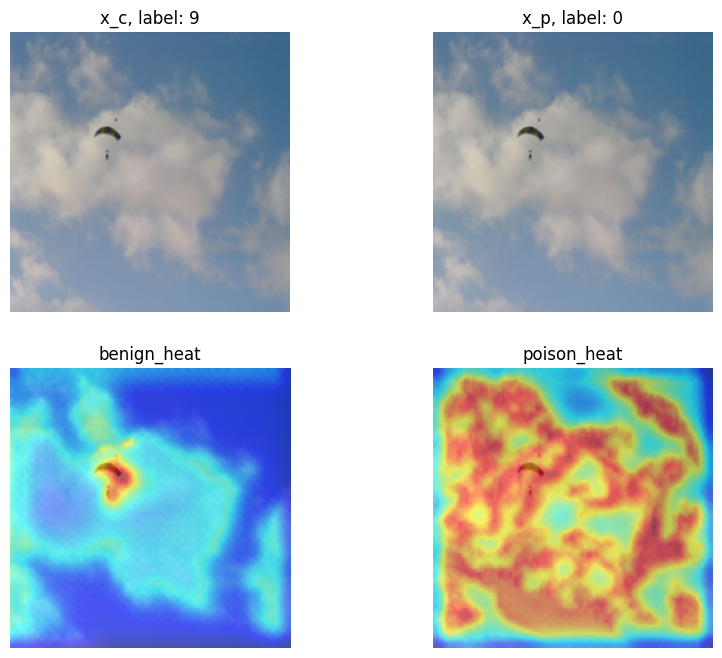

In [248]:
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

model.model.eval()
target_layers = [model.model.layer4[-1].conv2]
cam = FullGrad(model=model.model, target_layers=target_layers)

_, _, no_norm_ld = get_dataloader(dataset_name, batch)
x_benign, x_poison = None, None
ground_truth = 0

for x, y in iter(no_norm_ld):
    x_benign = x
    ground_truth = y
    break

x_benign = x_benign[0]
ground_truth = ground_truth[0]

x_c4visible = tensor2ndarray(x_benign) / 255.
x_p4visible = tensor2ndarray(patch_trigger(x_benign, attack_name)) / 255.



x_benign = norm(x_benign)
x_poison = patch_trigger(norm(x_benign), attack_name)

y_benign = torch.argmax(model.model(x_benign.unsqueeze(0))[0], dim=0).item()
y_poison = torch.argmax(model.model(x_poison.unsqueeze(0))[0], dim=0).item()

benign_heat = cam(x_benign.unsqueeze(0),targets=[ClassifierOutputTarget(y_benign)])
poison_heat = cam(x_poison.unsqueeze(0), targets=[ClassifierOutputTarget(y_poison)])

visualization_0 = show_cam_on_image(x_c4visible, benign_heat[0, :], use_rgb=True)
visualization_1 = show_cam_on_image(x_p4visible, poison_heat[0, :], use_rgb=True)

_, axs = plt.subplots(2, 2, figsize=(10, 8))
axs[0, 0].imshow(x_c4visible)
axs[0, 0].set_title(f'x_c, label: {ground_truth}')
axs[0, 0].axis('off')

axs[0, 1].imshow(x_p4visible)
axs[0, 1].set_title(f'x_p, label: {0}')
axs[0, 1].axis('off')

axs[1, 0].imshow(visualization_0)
axs[1, 0].set_title('benign_heat')
axs[1, 0].axis('off')

axs[1, 1].imshow(visualization_1)
axs[1, 1].set_title('poison_heat')
axs[1, 1].axis('off')
plt.show()